In [169]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10
num_features = 784

lr = 0.001
n_epochs = 10
batch_size = 256

In [3]:
# Dataset
# Model
# Training
# Error Analysis

In [32]:
df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")

In [41]:
X = df[df.columns[1:]].values
y = df["label"].values

In [42]:
X.shape

(60000, 784)

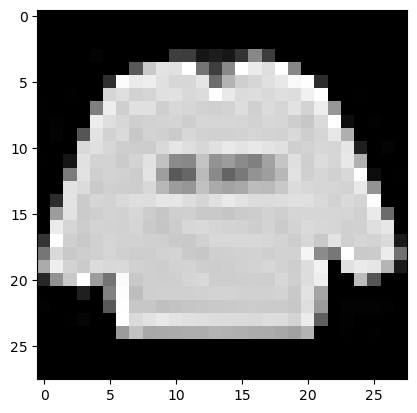

In [43]:
plt.imshow(X[0].reshape(28, 28), cmap="gray")

In [121]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True)

In [87]:
class Dataset:
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.X /= 255.
        self.y = y
        self.shuffle()
    
#     def __init__(self, image_ids: list):
#         self.image_ids = image_ids
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
#     def __getitem__(self, idx):
#         image_path = self.image_ids[idx]
#         image = cv2.imread(image_path)
#         image = transform(image)
#         return image, self.y[idx]
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
        
        self.shuffle()
            
    def shuffle(self):
        reidx = random.sample(
            population=list(range(self.__len__())),
            k=self.__len__()
        )
        self.X = self.X[reidx]
        self.y = self.y[reidx]

In [92]:
# c = 0
# for i, (_x, _y) in enumerate(train_data):
#     c += _y.shape[0]
    

In [99]:
class DenseLayer(tf.Module):
    def __init__(self, _in, _out, name=None, activation="relu"):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([_in, _out], stddev=0.05), name="w")
        self.b = tf.Variable(tf.zeros([_out]), name="b")
        self.activation = activation
    
    def __call__(self, x):
        y_in = tf.matmul(x, self.w) + self.b
        if self.activation == "relu":
            y = tf.nn.relu(y_in)
        if self.activation == "softmax":
            y = tf.nn.softmax(y_in)
        
        return y

    
class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name)
        self.layer_1 = DenseLayer(_in=28*28, _out=128)
        self.layer_2 = DenseLayer(_in=128, _out=128)
        self.layer_3 = DenseLayer(_in=128, _out=10, activation="softmax")
    
    def __call__(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [100]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(
        tf.argmax(y_pred, 1), 
        tf.cast(y_true, tf.int64)
    )
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [101]:
# 256 * 10 -> 256 * 1
# [3, 6, 1, 3, 7]
# [False, True, False, False]
# [0., 1., 0., 0.]

In [116]:
def train(nn, optimizer, input_x, output_y):
    with tf.GradientTape() as g:
        pred = nn(input_x)
        loss = cross_entropy(pred, output_y)

        gradients = g.gradient(loss, nn.variables)
        optimizer.apply_gradients(zip(gradients, nn.variables))
        
    return pred

In [124]:
class Trainer:
    def __init__(self, model, optimizer, n_epochs):
        self.model = model
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        
    def fit(self, train_dataset, valid_dataset):
        e_train_loss = []
        e_train_score = []
        e_valid_loss = []
        e_valid_score = []
        
        for epoch in range(self.n_epochs):
            print(f"{epoch=}")
            
            b_train_loss = []
            b_train_score = []
            for batch_x, batch_y in train_dataset:
                pred = train(self.model, self.optimizer, batch_x, batch_y)
                b_train_loss.append(cross_entropy(pred, batch_y))
                b_train_score.append(accuracy(pred, batch_y))
            
            e_train_loss.append(np.mean(b_train_loss))
            e_train_score.append(np.mean(b_train_score))
            
            b_valid_loss = []
            b_valid_score = []
            for batch_x, batch_y in valid_dataset:
                pred = self.model(batch_x)
                b_valid_loss.append(cross_entropy(pred, batch_y))
                b_valid_score.append(accuracy(pred, batch_y))
            
            e_valid_loss.append(np.mean(b_valid_loss))
            e_valid_score.append(np.mean(b_valid_score))
            
            print(f"{e_train_loss[-1]:.2f}, {e_train_score[-1]:.2f}, {e_valid_loss[-1]:.2f}, {e_valid_score[-1]:.2f}")
        
        return e_train_loss, e_train_score, e_valid_loss, e_valid_score

In [126]:
model = NN()
optimizer = tf.optimizers.SGD(lr)
train_dataset = Dataset(X_train, y_train)
train_data = tf.data.Dataset.from_generator(train_dataset, output_types=(tf.float32, tf.uint8))
train_data = train_data.batch(batch_size).prefetch(2)
valid_dataset = Dataset(X_valid, y_valid)
valid_data = tf.data.Dataset.from_generator(valid_dataset, output_types=(tf.float32, tf.uint8))
valid_data = valid_data.batch(batch_size).prefetch(2)

trainer = Trainer(model, optimizer, 8)
e_train_loss, e_train_score, e_valid_loss, e_valid_score = trainer.fit(train_data, valid_data)

epoch=0
222.27, 0.69, 138.33, 0.81
epoch=1
134.97, 0.81, 114.05, 0.84
epoch=2
119.85, 0.83, 105.61, 0.85
epoch=3
106.71, 0.85, 103.01, 0.85
epoch=4
99.55, 0.86, 99.05, 0.86
epoch=5
95.24, 0.86, 94.99, 0.86
epoch=6
92.81, 0.87, 92.31, 0.87
epoch=7
88.10, 0.87, 90.57, 0.87


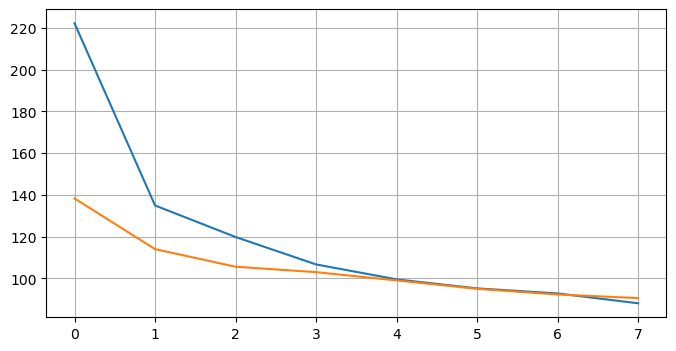

In [127]:
plt.figure(figsize=(8, 4))
plt.plot(e_train_loss)
plt.plot(e_valid_loss)
plt.grid()

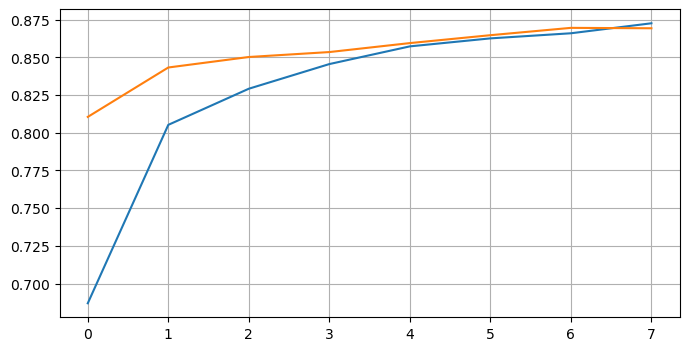

In [128]:
plt.figure(figsize=(8, 4))
plt.plot(e_train_score)
plt.plot(e_valid_score)
plt.grid()

In [129]:
df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

In [130]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [144]:
x_test_sample = df.iloc[:4, 1:].values

In [145]:
x_test_sample = x_test_sample.astype(np.float32)
x_test_sample /= 255.

In [147]:
test_out = model(x_test_sample)

In [148]:
test_out.numpy().argmax(axis=1)

array([0, 1, 2, 2])

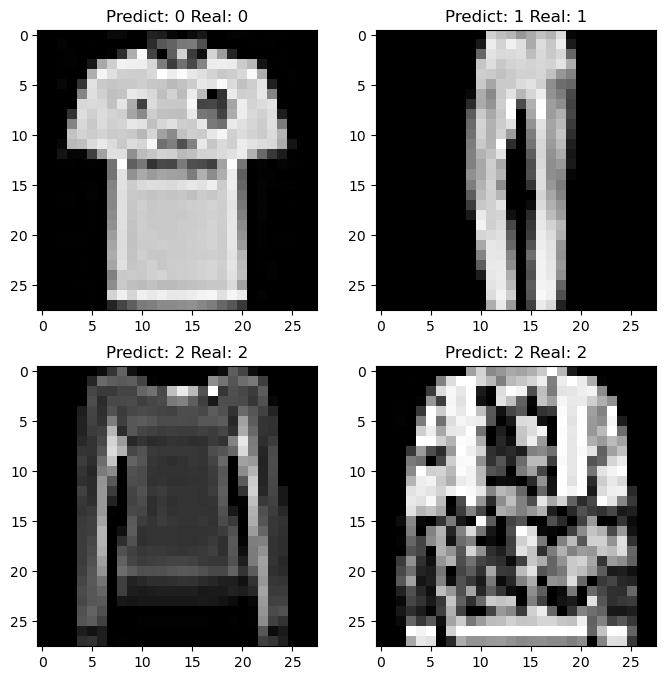

In [152]:
plt.figure(figsize=(8, 8))
for i, _x in enumerate(x_test_sample, 1):
    plt.subplot(2, 2, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {test_out.numpy().argmax(axis=1)[i - 1]} Real: {df.iloc[i-1, 0]}")

In [159]:
x_test = df.iloc[:, 1:].values
x_test = x_test.astype(np.float32)
x_test /= 255.

In [160]:
test_out = model(x_test).numpy()

In [164]:
y_pred_test = test_out.argmax(axis=1)
y_test = df.iloc[:, 0].values

In [166]:
np.mean(y_pred_test == y_test)

0.8738

In [173]:
arr = \
[
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

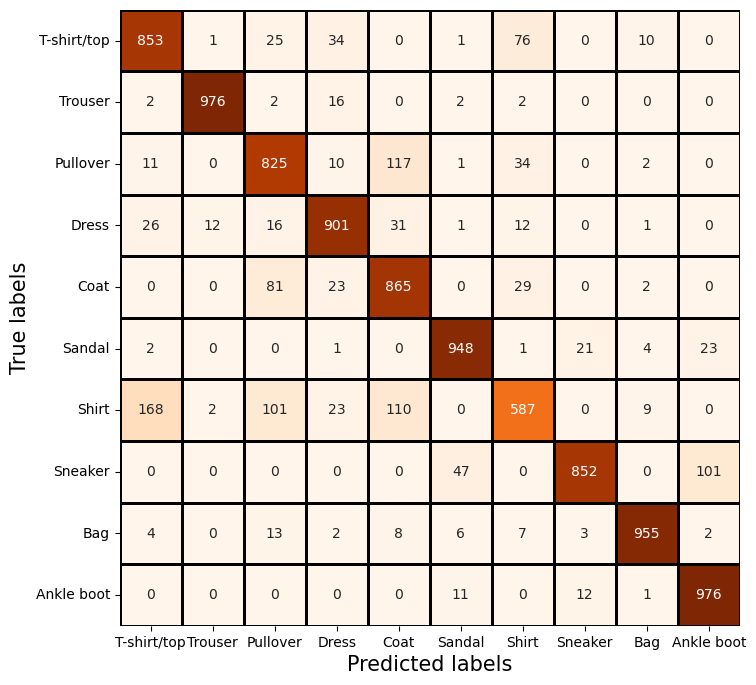

In [181]:
cm = confusion_matrix(y_test, y_pred_test)
df_confusion_matrix = pd.DataFrame(cm, index=arr, columns=arr)

plt.figure(figsize=(8, 8))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

In [183]:
ea = pd.DataFrame({"pred": y_pred_test, "y": y_test})

In [185]:
ea["equal"] = ea["pred"] == ea["y"]

In [187]:
ea[(ea["y"] == 6) & (ea["equal"] == False)]

,pred,y,equal
7,4,6,False
16,4,6,False
43,2,6,False
58,0,6,False
73,0,6,False
...,...,...,...
9867,2,6,False
9869,0,6,False
9913,2,6,False
9961,4,6,False


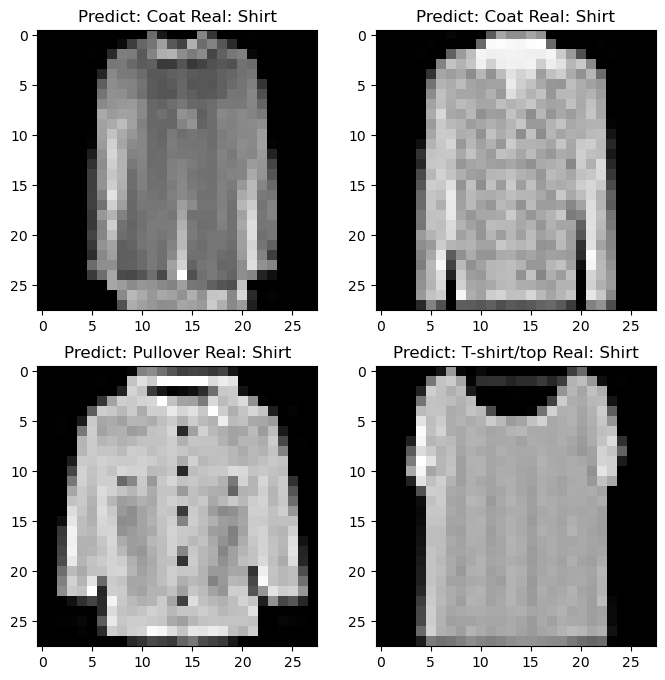

In [192]:
plt.figure(figsize=(8, 8))
index = [7, 16, 43, 58]
for i, _x in enumerate(x_test[index], 1):
    plt.subplot(2, 2, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {arr[y_pred_test[index[i - 1]]]} Real: {arr[y_test[index[i - 1]]]}")

In [ ]:
, 1